## Deterministric Model
### Exercise 1

In [11]:
import torch
import MNIST_dataloader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch import nn, optim
from typing import Dict, Optional, Tuple, List
from PIL import Image
import sys
from torch.utils.data import DataLoader
import pandas as pd
import torch.nn.functional as F



In [12]:
# %% set torches random seed
torch.random.manual_seed(0)

In [13]:
# %% preperations
# define parameters

data_loc = os.path.join(os.path.abspath("."),"MNIST") #change the data location to something that works for you
batch_size = 64
train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)


In [14]:
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

In [15]:
x_clean_example.shape

torch.Size([10, 1, 32, 32])

In [21]:
# Define Autoencoder
# Encoder

class Encoder(nn.Module):
    def __init__(self,in_channel=3):
        super(Encoder, self).__init__()
        # create layers here
        self.encoder = nn.Sequential(
        nn.Conv2d(in_channel,16,kernel_size=3,padding=1), #(N,3,32,32)->(N,16,32,32)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), #(N,16,32,32)->(N,16,16,16)
        nn.Conv2d(16,16,3,padding=1), #(N,16,16,16)->(N,16,16,16)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), # (N,16,16,16)->(N,16,8,8)
        nn.Conv2d(16,16,3,padding=1), #(N,16,8,8)->(N,16,8,8)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), # (N,16,4,4)
        nn.Conv2d(16,1,3,padding=1), #(N,16,4,4)->(N,1,4,4)
        nn.ReLU(),
        nn.MaxPool2d((2,4)) # (N,1,2,1)
        )
        
    def forward(self, x):
        # use the created layers here
        x = self.encoder(x)
        return x
    
# Decoder
class Decoder(nn.Module):
    def __init__(self,out_channel=3):
        super(Decoder, self).__init__()
        # create layers here
        self.decoder = nn.Sequential(
        nn.Upsample(scale_factor=(2,4)), #(N,1,2,1)->(N,1,4,4)
        nn.ConvTranspose2d(1,16,3,padding=1), # (N,16,4,4)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Upsample(scale_factor=2), #(N,16,4,4)->(N,16,8,8)
        nn.ConvTranspose2d(16,16,3,padding=1), # (N,16,8,8)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Upsample(scale_factor=2), #(N,16,8,8)->(N,16,16,16)
        nn.ConvTranspose2d(16,16,3,padding=1), # (N,16,16,16)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Upsample(scale_factor=2), #(N,16,32,32)->(N,16,32,32)
        nn.ConvTranspose2d(16,out_channel,3,padding=1), # (N,16,32,32)
        )
        
    def forward(self, h):
        # use the created layers here
        r = self.decoder(h)
        return r
    
# Autoencoder
class AE(nn.Module):
    def __init__(self,channel=3):
        super(AE, self).__init__()
        self.encoder = Encoder(channel)
        self.decoder = Decoder(channel)
        
    def forward(self, x):
        h = self.encoder(x)
        r = self.decoder(h)
        return r, h

In [22]:
# Sanity check
sanity_check = torch.ones((64,3,32,32))
encoder_check = Encoder(3)
latent = encoder_check.forward(sanity_check)
print(latent.shape)
decoder_check = Decoder(3)
print(decoder_check.forward(latent).shape)
AE_check = AE(3)
r,h = AE_check.forward(sanity_check)
print(r.shape)
print(h.shape)

torch.Size([64, 1, 2, 1])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 1, 2, 1])


## Trainer

In [18]:
class Trainer:
    def __init__(self,model:nn.Module,dataloader:Dict,epochs=4,batch_size=64):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = model.to(self.device)
        self.dl = dataloader
        self.optimizer = optim.Adam(model.parameters(),lr=1e-3)
        self.critereon = torch.nn.MSELoss()
        self.epochs = epochs
        self.batch_size = batch_size
    def train_epoch(self,dl_train):
        '''
        train
        return train_epoch_loss
        '''
        self.model.train()
        train_epoch_loss = []
        sys.stdout.flush()
        with tqdm(total=len(dl_train),desc=f'Training') as pbar:
            for inputs in dl_train:
                self.optimizer.zero_grad()
                inputs = inputs.to(device=self.device,dtype=torch.float32)
                outputs = self.model(inputs)
                loss=self.critereon(outputs,inputs)
                nn.utils.clip_grad_value_(self.model.parameters(),0.1)
                self.optimizer.step()
                step_metrics = loss.item()

                #update the progress bar
                pbar.set_postfix(step_metrics)
                pbar.update(list(inputs.shape)[0])

                train_epoch_loss.append(step_metrics)
        sys.stdout.flush()
        return train_epoch_loss

    def val_poch(self,dl_val):
        '''
        validation
        return val_epoch_loss
        '''
        self.model.eval()
        amount = 0
        total_loss = 0

        sys.stdout.flush()
        with torch.nograd(),tqdm(total=len(dl_val),desc=f"Validation") as pbar:
            for inputs in dl_val:
                inputs = inputs.to(device=self.device,dtype=torch.float32)
                outputs = self.model(inputs)
                loss = self.critereon(outputs,inputs)
                step_metrics = loss.item()
                #update the progress bar
                pbar.set_postfix(step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount +=1
                total_loss += step_metrics
        sys.stdout.flush()

        val_epoch_loss = total_loss/amount
        print(f'Validation loss is {total_loss}')
        
        return val_epoch_loss

    def fit(self):
        '''
        train and val in epochs
        return train_loss,val_loss
        '''
        dl_train,dl_val = torch.utils.data.random_split(self.dl, [50000, 10000])
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()
        for epoch in range(1,self.epochs+1):
            print(f'Epoch {epoch}')
            train_loss = self.train_epoch(dl_train)
            df_train = df_train.append({'epoch':[epoch for _ in range(len(train_loss))],'train_loss':train_loss},ignore_index=True)
            val_loss = self.val_poch(dl_val)
            df_val = df_val.append({'epoch':[epoch for _ in range(len(val_loss))],'train_loss':val_loss},ignore_index=True)

        del dl_train
        del dl_val
        return df_train,df_val


In [23]:
model_1 = AE(1)
no_epochs = 4
learning_rate = 3e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer_1 = optim.Adam(model_1.parameters(),lr = learning_rate)
critereon = nn.MSELoss()


In [24]:
#using clean image to train x_clean_train
model_1.train()
loss_iter = []
loss_epoch = []
torch.random.manual_seed(0)
for epoch in range(no_epochs):
    print(f"Training on {device}. Epoch {epoch+1}:")
    # go over all minibatches
    sys.stdout.flush()
    total_loss=0
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        optimizer_1.zero_grad()
        inputs = x_clean.to(device=device)
        model_1 = model_1.to(device=device)
        outputs,latent = model_1(inputs)
        loss = critereon(outputs,inputs)
        loss.backward()
        optimizer_1.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    print(f'epoch[{epoch+1}/{no_epochs}],MSE loss:{total_loss/len(train_loader)}')
    sys.stdout.flush()
        

Training on cpu. Epoch 1:


100%|██████████| 938/938 [01:23<00:00, 11.18it/s]

epoch[1/5],MSE loss:0.24492523074150085
Training on cpu. Epoch 2:



100%|██████████| 938/938 [01:10<00:00, 13.28it/s]

epoch[2/5],MSE loss:0.18384891748428345
Training on cpu. Epoch 3:



100%|██████████| 938/938 [01:15<00:00, 12.44it/s]

epoch[3/5],MSE loss:0.17629826068878174
Training on cpu. Epoch 4:



100%|██████████| 938/938 [01:10<00:00, 13.38it/s]

epoch[4/5],MSE loss:0.17209044098854065


In [25]:
model_loc = os.path.join(os.path.abspath("."),"model")
torch.save(model_1,os.path.join(model_loc,"exercise1.pth"))

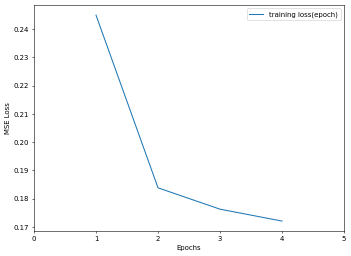

In [29]:
"""
Visualize the first 10 images of example_clean next to the output of this batch. What
differences/resemblances you do notice between the input and output of the autoencoder?
Also make a plot of the loss as a function of the number of iterations or epochs.
"""
plt.figure(figsize=(8,6),dpi=50, facecolor='w', edgecolor='k')
# plt.plot(range(len(loss_iter)),loss_iter,label='training loss(iteration)',linestyle=':')
plt.plot(range(1,no_epochs+1),loss_epoch,label='training loss(epoch)',linestyle='-')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.xlim((0,no_epochs+1))
# plt.ylim((0,1))
plt.show()

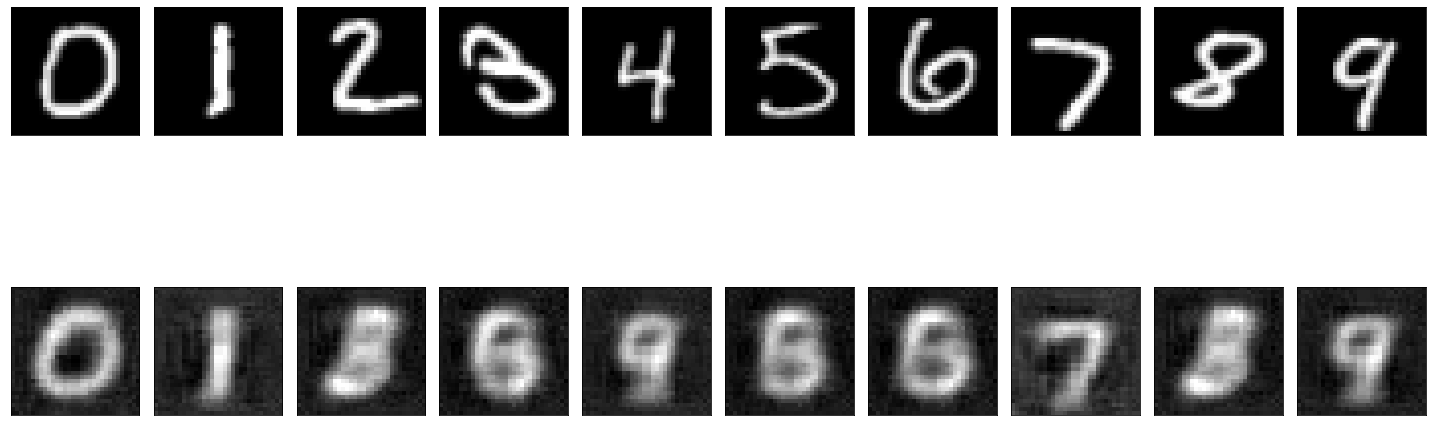

In [30]:
# x_clean_test = train_loader.dataset.Clean_Images
# x_clean_example = x_clean_test[0:10,:,:,:]
# with torch.no_grad():
#     outputs_clean,_ = model_1(x_clean_example)

examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
with torch.no_grad():
    outputs_clean,latent = model_1(x_clean_example)


plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,10,i+11)
    plt.imshow(outputs_clean[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath("."),"figure")
plt.savefig(os.path.join(fig_path,"exercise1_examples.png"),dpi=80,bbox_inches='tight')
plt.show()

-  2->3
-  3->6/8 
-  4->9
-  5->8
-  6->8
-  8->3

## Exercise 2

In [85]:
model_1.eval()
with torch.no_grad():
    _,latent = model_1(x_clean_test)
latent=latent.squeeze()


In [86]:
latent.size()

torch.Size([10000, 2])

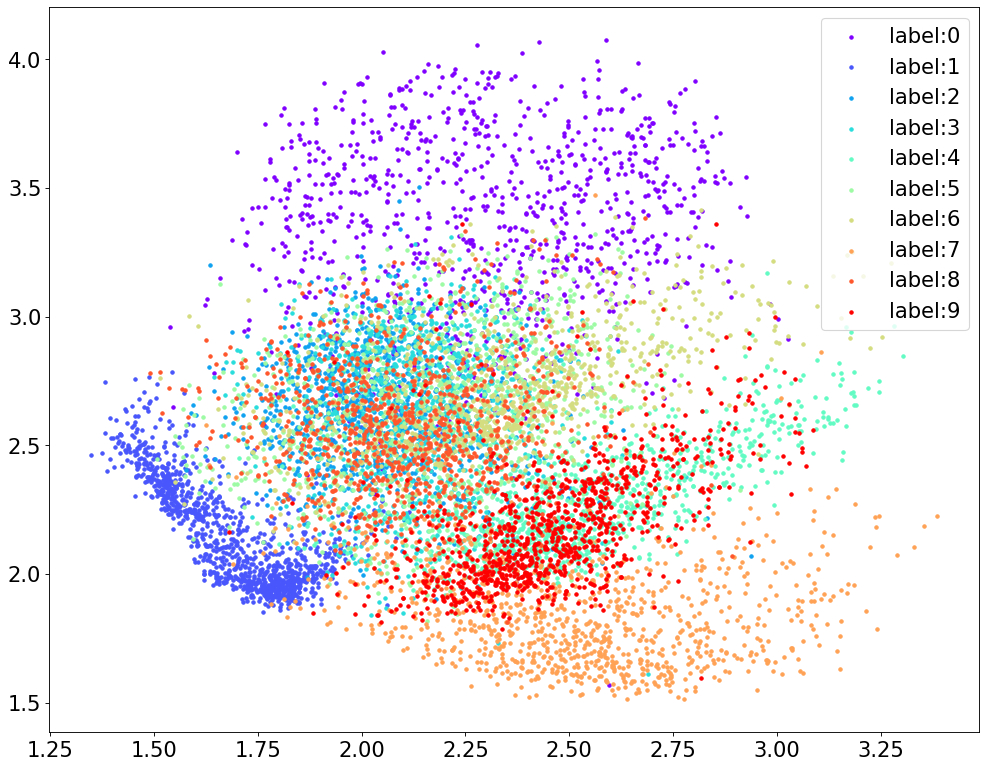

In [114]:
import matplotlib.cm as cm
import numpy as np

colors = cm.rainbow(np.linspace(0, 1,10))
plt.figure(figsize=(15,12),dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
    c = colors[i]
    latent_c = latent[torch.where(labels_test==i)]
    # if i == 3 or i==6:
    plt.scatter(latent_c[:,0], latent_c[:,1], color=c,label=f"label:{i}",marker='.')

plt.xticks(size=19)
plt.yticks(size=19)
plt.legend(loc=1,prop={'size': 19})
plt.savefig(os.path.join(fig_path,"Exercise2.png"),dpi=80,bbox_inches='tight')
plt.show()

### 2b)
- 0,1,9 provide clear clusters.
- Others are overlapped?
### 2c)
- What does it mean?

## Exercise 3